Maya Fetzer and Brandon Roman

FA 2024

CHEG 472



---


Hooplas LangChain Final Team Project

The goal of this project is to create a LangChain chat bot that will answer questions about mini bowling throw angle and speed in order to improve the number of pins that were knocked down.

##Imports

In [ ]:
# Import necessary libraries
!pip install shap -q
!pip install pickle-mixin -q
!pip install numpy -q
!pip install langchain -q
!pip install openai -q
!pip install langchain-community -q
!pip install langchain-openai -q


import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
import joblib
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

import pickle
from langchain.prompts import PromptTemplate
from langchain.agents import initialize_agent, Tool, AgentType
from langchain.agents import AgentExecutor
from langchain.memory import ConversationBufferMemory

# Import filters to remove unnecessary warnings
from warnings import simplefilter
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import ConvergenceWarning

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Import filters to remove unnecessary warnings
from warnings import simplefilter
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error
import shap

import pickle
import openai
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain
import re
from IPython.display import display, Markdown

## Step 1: Preprocessing

---



In order to make a machine learning model, you need a dataset in order to train the model. For this project, we collected a dataset at Hooplas of mini bowling.

In [ ]:
import pandas as pd

# Replace '/path/to/your/file.xlsx' with the actual file path
file_path = '/content/hooplas_dataset.xlsx'

# Read the Excel file into a Pandas DataFrame
df = pd.read_excel(file_path)

# Print the first few rows of the DataFrame
print("The first 5 rows of the dataset:")
print(df.head())

# Print the description of the DataFrame
print("The descriptive statistics of the dataset")
print(df.describe())

# Get the data types of all columns
data_types = df.dtypes
# Print the datatypes of each column
print("The data types of each column:")
print(data_types)

# Get the numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
# Get the categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
# Print the results
print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

The first 5 rows of the dataset:
  Player_Name  Round  Pins_Knocked   Throw_Angle    Speed  Total_Score
0        Josh      1              9            10    fast            9
1    Brandon       1              6            25  medium            6
2       Cole       1              8            20    fast            8
3       Maya       1              7            15  medium            7
4        Josh      2              8             5    fast           17
The descriptive statistics of the dataset
           Round  Pins_Knocked   Throw_Angle   Total_Score
count  40.000000      40.000000     40.000000    40.000000
mean    5.500000       8.125000     11.500000    43.400000
std     2.908872       2.593755      6.998168    23.263044
min     1.000000       1.000000      5.000000     6.000000
25%     3.000000       7.000000      5.000000    25.000000
50%     5.500000       8.000000     10.000000    42.000000
75%     8.000000       9.000000     15.000000    62.250000
max    10.000000      17.00

We can drop irrelevant information from the dataset, which includes the round number and the player name. This will also allow the final dataset to not have any personal information about the people in the dataset. We can also remove the total score of each of the players because we are just focusing on the per round scores for the target of the ML model. This will leave only the features (speed and angle) and target (pins knocked).

In [ ]:
df = df.drop(['Round','Player_Name','Total_Score'],axis=1)

Next, we can check for missing values in the dataset. When creating a ML model, it is very important that your columns don't contain missing data because that can skew the model and make it less accurate.

In [ ]:
import pandas as pd
import numpy as np

missing_data = df.isnull().sum()
print("Total missing values:")
print(missing_data)

Total missing values:
Pins_Knocked     0
Throw_Angle      0
Speed            0
dtype: int64


This dataset has no missing data, so we don't need to worry about any missing data handling. This makes sense because we collected all of the datapoints individually and made sure not to miss any data points when collecting the data as to ensure the highest accuracy of the set.

Next, we can check for outliers. It is important to handle outliers because they can also skew any machine learning models that are derived from the dataset. So, we first need to locate the outliers. If there are outliers, we can decide what to do with them based on the quantity of outliers in the dataset.

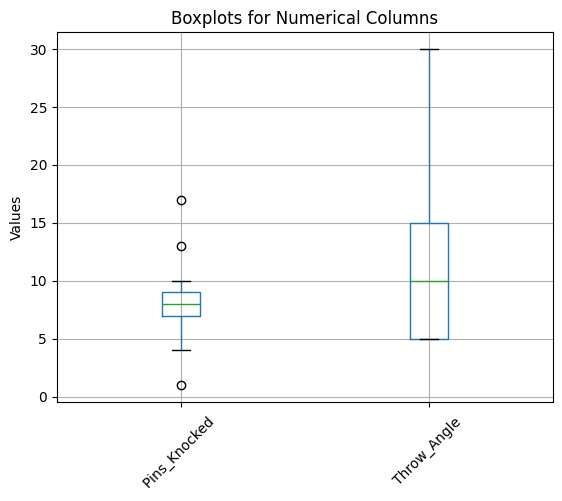

Outliers in column 'Pins_Knocked ': [1, 17, 13]
No outliers found in column 'Throw_Angle '


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate outliers for each column
outliers_dict = {}

# Only check the columns that are numerical and would contain outliers
columns_to_check = df.select_dtypes(include=['int64', 'float64']).columns

# Create boxplots for specified columns
df[columns_to_check].boxplot()
plt.title("Boxplots for Numerical Columns")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.show()

# Check for outliers and plot the boxplot
for col in columns_to_check:
   q1 = np.quantile(df[col], 0.25)
   q3 = np.quantile(df[col], 0.75)
   iqr = q3 - q1
   lower_bound = q1 - 1.5 * iqr
   upper_bound = q3 + 1.5 * iqr
   outliers = df[col][(df[col] < lower_bound) | (df[col] > upper_bound)]
   outliers_dict[col] = outliers.tolist()

# Print outliers for each column
for col, outliers in outliers_dict.items():
   if outliers:
       print(f"Outliers in column '{col}': {outliers}")
   else:
       print(f"No outliers found in column '{col}'")

There are outliers in this dataset, but there is also not a lot of data points. Removing the outliers could remove too large of a portion of the dataset and make the ML model that we are writing inaccurate, so for now the outliers can stay in the set.

Next, we need to one-hot encode the categorical variables in the dataframe. This will allow a machine learning model to handle the categorical variables by transforming them into binary vectors where if the category is true, the value is 1 and if it is false the value is 0.

In [ ]:
# Perform one-hot encoding
df = pd.get_dummies(df, columns=['Speed'], prefix='', prefix_sep='')

# Ensure all NaN values are replaced with 0
df = df.fillna(0).astype(int)
print(df)

    Pins_Knocked   Throw_Angle   fast  medium
0               9            10     1       0
1               6            25     0       1
2               8            20     1       0
3               7            15     0       1
4               8             5     1       0
5               8            10     1       0
6              10            10     0       1
7               9             5     0       1
8               8            10     1       0
9               8            10     0       1
10              8            10     1       0
11              9             5     1       0
12              9             5     1       0
13              7            10     0       1
14              4            20     0       1
15              8            10     0       1
16              9             5     1       0
17              8             5     1       0
18             10            10     0       1
19              4            25     0       1
20              6             5   

Finally, we can normalize the dataframe. There are a lot of different
numerical categories in this dataframe, and making sure that they are normalized
will improve the accuracy of the model and prevent it from being skewed by numbers that are very different in magnitude.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Assuming 'df' is your DataFrame and you want to normalize all columns
scaler = MinMaxScaler()

# Normalize the DataFrame
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Display the normalized DataFrame
print(df)

    Pins_Knocked   Throw_Angle   fast  medium
0          0.5000           0.2   1.0     0.0
1          0.3125           0.8   0.0     1.0
2          0.4375           0.6   1.0     0.0
3          0.3750           0.4   0.0     1.0
4          0.4375           0.0   1.0     0.0
5          0.4375           0.2   1.0     0.0
6          0.5625           0.2   0.0     1.0
7          0.5000           0.0   0.0     1.0
8          0.4375           0.2   1.0     0.0
9          0.4375           0.2   0.0     1.0
10         0.4375           0.2   1.0     0.0
11         0.5000           0.0   1.0     0.0
12         0.5000           0.0   1.0     0.0
13         0.3750           0.2   0.0     1.0
14         0.1875           0.6   0.0     1.0
15         0.4375           0.2   0.0     1.0
16         0.5000           0.0   1.0     0.0
17         0.4375           0.0   1.0     0.0
18         0.5625           0.2   0.0     1.0
19         0.1875           0.8   0.0     1.0
20         0.3125           0.0   

Finally, we can export the normalized, encoded, and cleaned dataset to an csv file. This way if someone is trying to perform machine learning on the model they don't need to redo all of the steps above and can start with a dataset that is ready for modeling.

In [ ]:
# Export DataFrame to CSV
csv_filename = 'hooplas_cleaned.csv'  # Specify your file name
df.to_csv(csv_filename, index=False)  # Use index=False to exclude row indices from the CSV

print(f"DataFrame exported successfully to {csv_filename}")

DataFrame exported successfully to hooplas_cleaned.csv


## Step 2: Exploratory Data Analysis

---

In order to understand how to train the machine learning model, we need to look at the different trends that are present in the dataset. This will allow for further understanding of the dataset and so that we can create a better machine learning model.

To better understand the trends of the data, we want to then look at the pairplots to better understand if there are variables that relate strongly with one another. This will be helpful when we need to go through and reduce the dataset to make it more fit for machine learning analysis. Further, this can help us isolate which variables to target as the strongest correlations in the dataset.

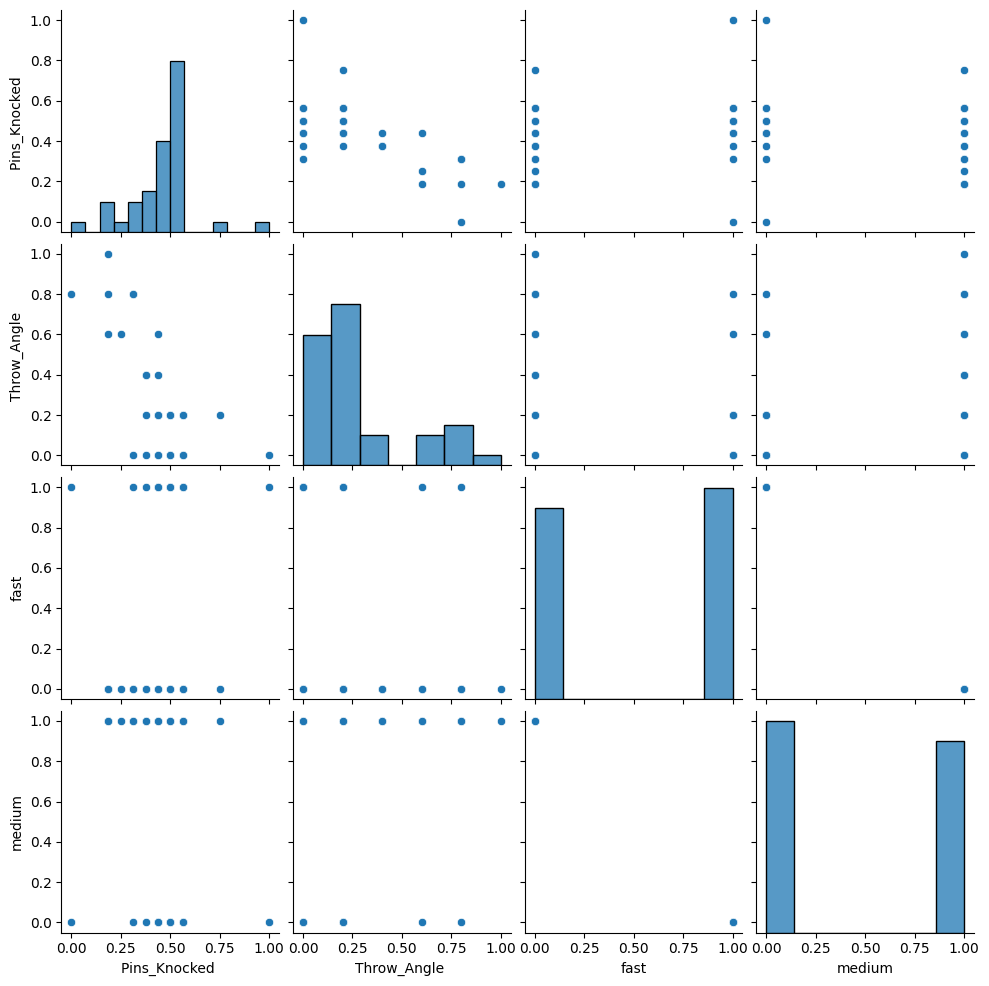

In [ ]:
import seaborn as sns
sns.pairplot(df)

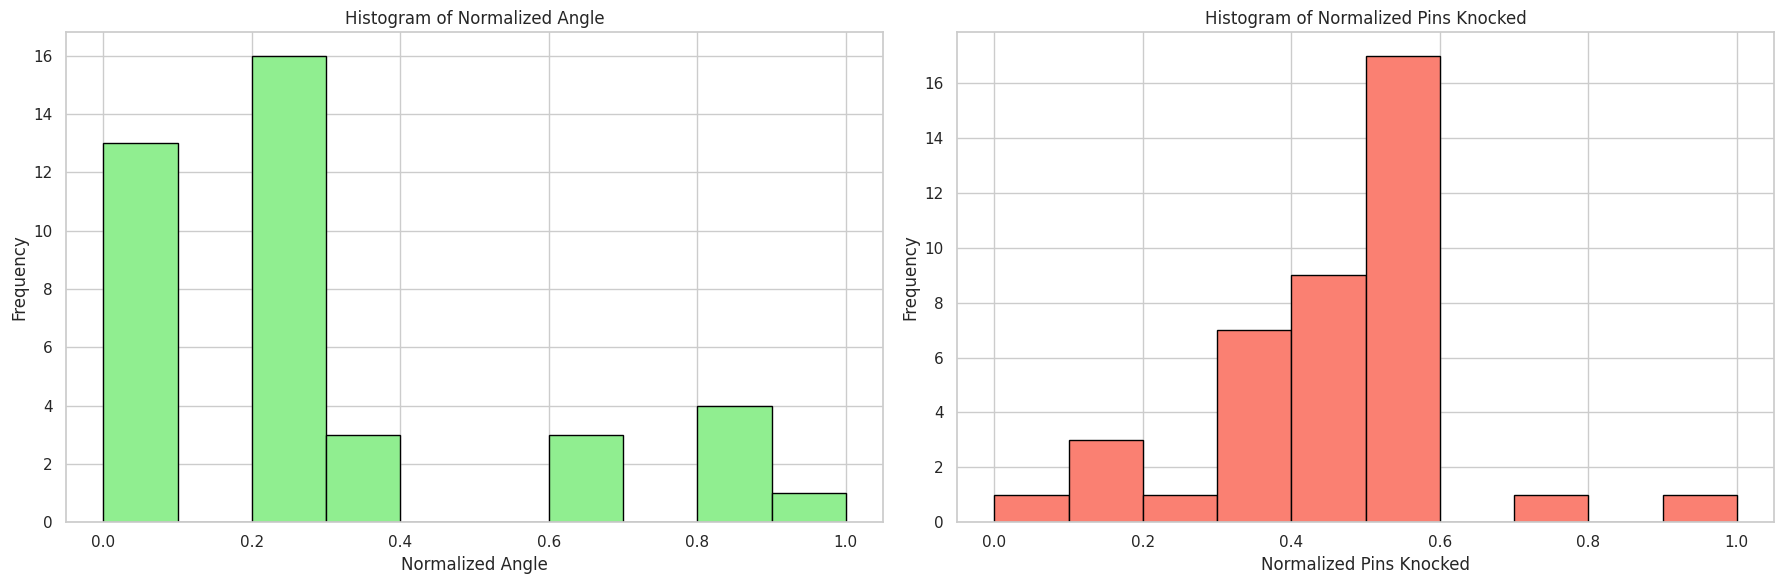

In [ ]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Create a figure with multiple subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histogram for normalized Throw_Angle (Bins range from 0 to 1)
axes[0].hist(df['Throw_Angle '], bins=10, edgecolor='black', color='lightgreen')
axes[0].set_title('Histogram of Normalized Angle')
axes[0].set_xlabel('Normalized Angle')
axes[0].set_ylabel('Frequency')

# Histogram for normalized Pins_Knocked (Bins range from 0 to 1)
axes[1].hist(df['Pins_Knocked '], bins=10, edgecolor='black', color='salmon')
axes[1].set_title('Histogram of Normalized Pins Knocked')
axes[1].set_xlabel('Normalized Pins Knocked')
axes[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the histograms
plt.show()


Looking at the distrubutions of normalized angles and number of pins knocked, we can also see that the players perferred lower angles, yet the distrubution for the number of pins knocked was relatively normal in shape.

               Pins_Knocked   Throw_Angle       fast    medium
Pins_Knocked        1.000000     -0.667458  0.202801 -0.202801
Throw_Angle        -0.667458      1.000000 -0.409332  0.409332
fast                0.202801     -0.409332  1.000000 -1.000000
medium             -0.202801      0.409332 -1.000000  1.000000


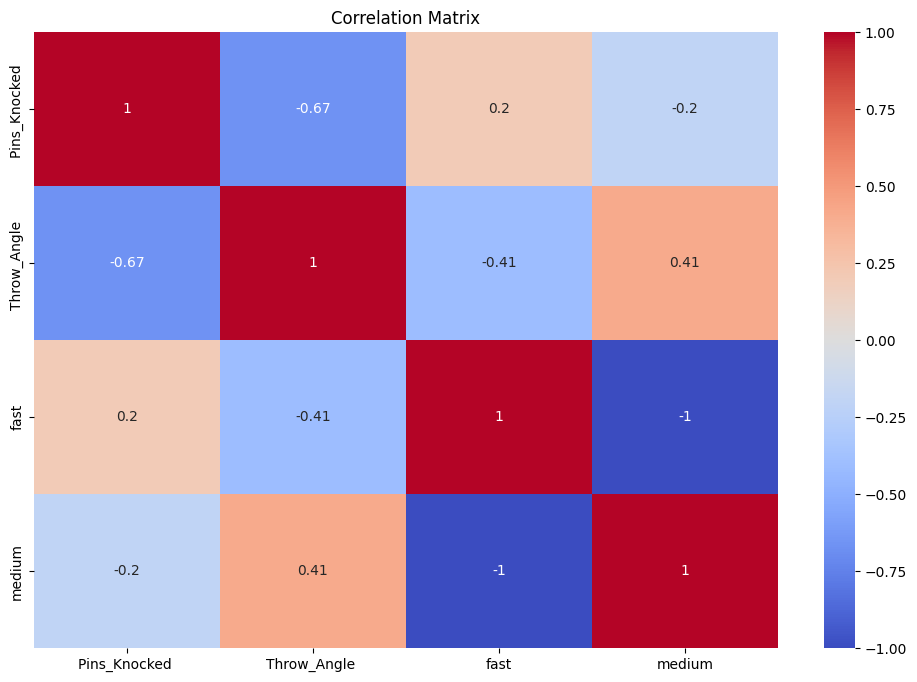

        feature1       feature2  correlation
0  Pins_Knocked   Pins_Knocked           1.0
1   Throw_Angle    Throw_Angle           1.0
2           fast           fast          1.0
3           fast         medium         -1.0
4         medium           fast         -1.0
5         medium         medium          1.0


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Print the correlation matrix
print(correlation_matrix)

# Create a heatmap to visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Analyze significant correlations
significant_correlations = correlation_matrix[(correlation_matrix > 0.7) | (correlation_matrix < -0.7)]
significant_correlations = significant_correlations.stack().reset_index()
significant_correlations.columns = ['feature1', 'feature2', 'correlation']
print(significant_correlations)

Based on this, there are no strong trends between the number of pins knocked down and the throw speed when the speed is fast or medium this dataset. However, there is a significant trend between the throw angle and the number of pins knocked down in the dataset. Higher angles are correlated with lower scores.

## Step 3: Machine Learning Model

---

To determine the best machine learning model for predicting the number of pins knocked down in bowling based on throw speed and angle, we tested several different models. We used a variety of algorithms, each with unique characteristics, to evaluate their performance on our dataset. The models we tested included **Random Forest**, **Gradient Boosting**, **MLP (Multi-layer Perceptron)**, **SVR (Support Vector Regressor)**, and **Linear Regression**. By training and testing each model on the same dataset, we were able to compare their performance in terms of prediction accuracy. This process helped us identify which model achieved the best results and was most suited for our specific task, ensuring that we chose the most accurate and reliable model for bowling prediction.


Random Forest:
  Average RMSE: 0.136
  Average MAE: 0.100
  Average R² Test Score: -0.088
  Average R² Train Score: 0.550
 
Gradient Boosting:
  Average RMSE: 0.142
  Average MAE: 0.104
  Average R² Test Score: -0.177
  Average R² Train Score: 0.567
 
MLP:
  Average RMSE: 0.140
  Average MAE: 0.102
  Average R² Test Score: -0.118
  Average R² Train Score: 0.504
 
SVR:
  Average RMSE: 0.137
  Average MAE: 0.099
  Average R² Test Score: -0.074
  Average R² Train Score: 0.498
 
Linear Regression:
  Average RMSE: 0.134
  Average MAE: 0.097
  Average R² Test Score: -0.030
  Average R² Train Score: 0.490
 

Best model based on Test R² performance:
Model             MLP
R^2 Test      0.53587
R^2 Train    0.374519
Name: 13, dtype: object


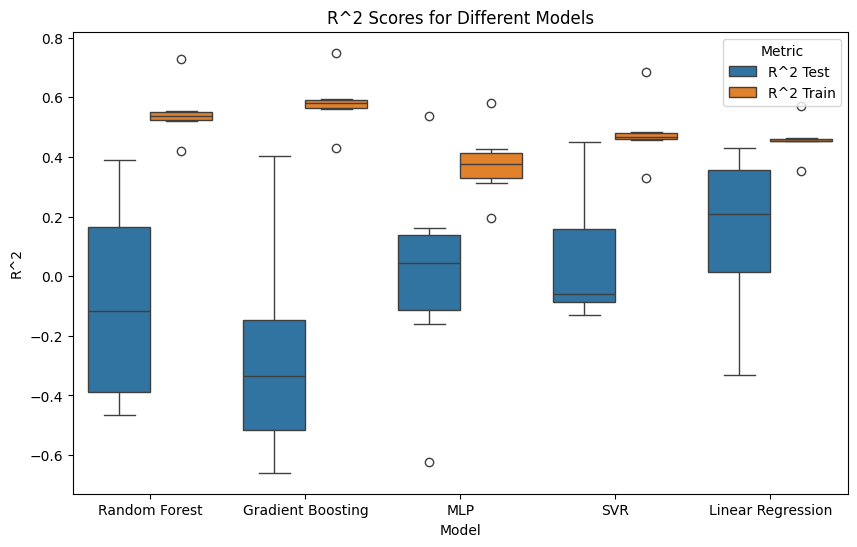

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Split the dataset into features and target
X = df.drop('Pins_Knocked ', axis=1)
Y = df['Pins_Knocked ']

# Define the number of folds for K-Fold cross-validation
n_folds = 6

# Initialize empty lists to store evaluation metrics
rmse_scores = []
mae_scores = []
r2_test_scores = []
r2_train_scores = []

# Define the models dictionary
models = {
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'MLP': MLPRegressor(),
    'SVR': SVR(),
    'Linear Regression': LinearRegression(),
}

# K-Fold cross-validation loop
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
for name, model in models.items():
    # Loop through each fold
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        # Train the model on the training data for this fold
        model.fit(X_train, y_train)

        # Predict on the testing data for this fold
        y_pred = model.predict(X_test)

        # Calculate evaluation metrics
        rmse = mean_squared_error(y_test, y_pred, squared=False)  # Calculate RMSE directly
        mae = mean_absolute_error(y_test, y_pred)
        r2_test = r2_score(y_test, y_pred)

        # Additionally, calculate R-squared on the training data for each fold (optional)
        y_train_pred = model.predict(X_train)
        r2_train = r2_score(y_train, y_train_pred)

        # Calculate R^2 difference
        r2_diff = r2_train - r2_test

        # Append the scores to the lists
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_test_scores.append(r2_test)
        r2_train_scores.append(r2_train)

    # Print average scores after all folds for each model
    print(f"{name}:")
    print(f"  Average RMSE: {np.mean(rmse_scores):.3f}")
    print(f"  Average MAE: {np.mean(mae_scores):.3f}")
    print(f"  Average R² Test Score: {np.mean(r2_test_scores):.3f}")
    print(f"  Average R² Train Score: {np.mean(r2_train_scores):.3f}")
    print(' ')

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'Random Forest', 'Random Forest', 'Random Forest', 'Random Forest', 'Random Forest',
              'Gradient Boosting', 'Gradient Boosting', 'Gradient Boosting', 'Gradient Boosting', 'Gradient Boosting', 'Gradient Boosting',
              'MLP', 'MLP', 'MLP', 'MLP', 'MLP', 'MLP',
              'SVR', 'SVR', 'SVR', 'SVR', 'SVR', 'SVR',
              'Linear Regression', 'Linear Regression', 'Linear Regression', 'Linear Regression', 'Linear Regression', 'Linear Regression'],
    'R^2 Test': r2_test_scores,
    'R^2 Train': r2_train_scores,
})

# Select the best model based on Test R², or lowest RMSE if R² is identical
best_model_row = results_df.loc[results_df['R^2 Test'].idxmax()]

print("\nBest model based on Test R² performance:")
print(best_model_row)

# Assuming 'results_df' is the DataFrame containing the model performance metrics
models = results_df['Model']
train_r2 = results_df['R^2 Train']
test_r2 = results_df['R^2 Test']

# Melt the DataFrame for easier plotting
melted_df = results_df.melt(id_vars='Model', var_name='Metric', value_name='R^2')

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='R^2', hue='Metric', data=melted_df)
plt.title('R^2 Scores for Different Models')
plt.xlabel('Model')
plt.ylabel('R^2')
plt.legend(title='Metric')
plt.show()

According to the above analysis, the best model (the model with the best R2 value, RSME value, and MAE value) will be linear regression. So, going forward, because we want the most accurate ML model possible, we will be using a linear regression model.

None of the models show a very good R2, RSME, or MAE. This is because, after looking at the EDA, we can see that there isn't a very strong correlation between the score achieved and the speed or throw angle. This means that there are probably other variables influencing the score that we didn't measure. For now, we cannot collect more data and so we should move on with the best model.

Running this multiple times, different models had different R2, RSME, MAE based on the test-train split. They are all not great because the data doesn't have strong correlations. However, linear regression seems to have a consistently ok R2 value and so we will move forward with that.

Fold 1:
  R² (train): 0.4533
  R² (test): 0.3709
  RMSE: 0.1156
  MAE: 0.0841
------------------------------
Fold 2:
  R² (train): 0.4559
  R² (test): 0.2482
  RMSE: 0.0714
  MAE: 0.0634
------------------------------
Fold 3:
  R² (train): 0.4512
  R² (test): 0.3623
  RMSE: 0.0598
  MAE: 0.0502
------------------------------
Fold 4:
  R² (train): 0.4395
  R² (test): 0.4044
  RMSE: 0.2108
  MAE: 0.1498
------------------------------
Fold 5:
  R² (train): 0.4981
  R² (test): -0.2228
  RMSE: 0.1313
  MAE: 0.1090
------------------------------

Average Scores Across All Folds:
  Average R² (train): 0.4596
  Average R² (test): 0.2326
  Average RMSE: 0.1178
  Average MAE: 0.0913


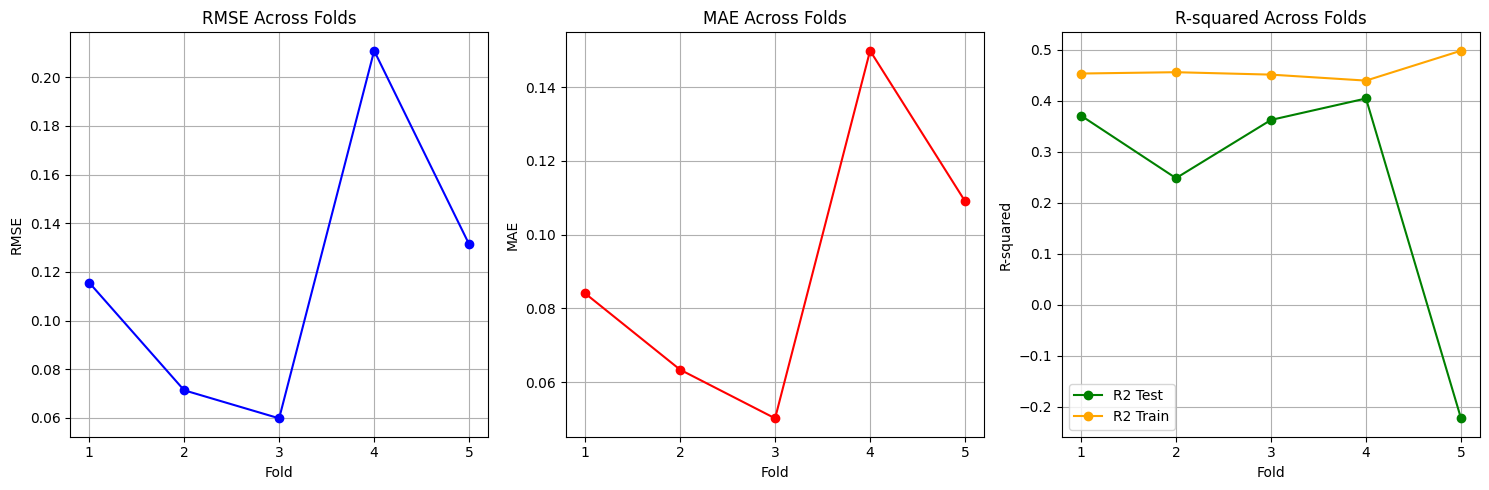

Model has been saved to best_model.pkl


In [ ]:
# Initialize the model
model = LinearRegression()

# Initialize lists to store metrics
rmse_scores = []
mae_scores = []
r2_test_scores = []
r2_train_scores = []

# Define K-Fold parameters
n_folds = 5  # Adjust this to the number of folds you want
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Loop through each fold
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Train the model on the training data for this fold
    model.fit(X_train, y_train)

    # Predict on the testing data for this fold
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # Calculate RMSE directly
    mae = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)

    # Additionally, calculate R-squared on the training data for each fold
    y_train_pred = model.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)

    # Append the scores to the lists
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_test_scores.append(r2_test)
    r2_train_scores.append(r2_train)

    # Print the scores for each fold
    print(f"Fold {fold}:")
    print(f"  R² (train): {r2_train:.4f}")
    print(f"  R² (test): {r2_test:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print("-" * 30)

# Now calculate and print the average scores across all folds
avg_rmse = sum(rmse_scores) / n_folds
avg_mae = sum(mae_scores) / n_folds
avg_r2_test = sum(r2_test_scores) / n_folds
avg_r2_train = sum(r2_train_scores) / n_folds

print("\nAverage Scores Across All Folds:")
print(f"  Average R² (train): {avg_r2_train:.4f}")
print(f"  Average R² (test): {avg_r2_test:.4f}")
print(f"  Average RMSE: {avg_rmse:.4f}")
print(f"  Average MAE: {avg_mae:.4f}")

# Check if the number of scores matches the number of folds
assert len(rmse_scores) == n_folds, f"Expected {n_folds} RMSE values, but got {len(rmse_scores)}"
assert len(mae_scores) == n_folds, f"Expected {n_folds} MAE values, but got {len(mae_scores)}"
assert len(r2_test_scores) == n_folds, f"Expected {n_folds} R2 test values, but got {len(r2_test_scores)}"
assert len(r2_train_scores) == n_folds, f"Expected {n_folds} R2 train values, but got {len(r2_train_scores)}"

# Now plot the metrics across the different folds

# Set up the figure size
plt.figure(figsize=(15, 5))

# Plot RMSE across the folds
plt.subplot(1, 3, 1)
plt.plot(range(1, n_folds + 1), rmse_scores, marker='o', color='blue', label='RMSE')
plt.title('RMSE Across Folds')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.xticks(range(1, n_folds + 1))
plt.grid(True)

# Plot MAE across the folds
plt.subplot(1, 3, 2)
plt.plot(range(1, n_folds + 1), mae_scores, marker='o', color='red', label='MAE')
plt.title('MAE Across Folds')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.xticks(range(1, n_folds + 1))
plt.grid(True)

# Plot R-squared (test) across the folds
plt.subplot(1, 3, 3)
plt.plot(range(1, n_folds + 1), r2_test_scores, marker='o', color='green', label='R2 Test')
plt.plot(range(1, n_folds + 1), r2_train_scores, marker='o', color='orange', label='R2 Train')
plt.title('R-squared Across Folds')
plt.xlabel('Fold')
plt.ylabel('R-squared')
plt.xticks(range(1, n_folds + 1))
plt.grid(True)
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Specify the file name for the pickle file
pickle_filename = 'best_model.pkl'

# Open the file in write-binary mode and save the model
with open(pickle_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Model has been saved to {pickle_filename}")

## Step 4: Export to LangChain

---

In this step, the machine learning model's outputs and processes are integrated into LangChain, a framework designed to manage and orchestrate language model applications. LangChain facilitates seamless interaction between the model and external tools, databases, or APIs by providing a structured environment for handling language model-driven tasks. Exporting to LangChain enables the model to be used within complex workflows, such as chaining together multiple models, interacting with data sources, or managing conversational contexts. This step ensures that the ML model can be deployed in a flexible, scalable, and production-ready system, allowing for improved task automation, user interaction, and decision-making capabilities.

In [ ]:
import pickle
import openai
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain
import re
from IPython.display import display, Markdown

# Set your OpenAI API key
# Add your personal API key here. The API key used during testing has been removed to
# ensure that private information of the owner is not leaked.
openai.api_key = 'ADD KEY HERE'

# Load your pre-trained model (Linear Regression model)
with open('best_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

# Assuming we know the normalization parameters used during training
# Replace these values with the actual parameters used in your case
mean_angle = 15  # Example mean value for the angle (replace with your actual mean)
std_angle = 5  # Example standard deviation for the angle (replace with your actual std)
mean_pins = 5  # Example mean value for the pins (replace with your actual mean)
std_pins = 2  # Example standard deviation for the pins (replace with your actual std)

# Initialize OpenAI Chat-based model using LangChain
chat_model = ChatOpenAI(model="gpt-4", api_key=openai.api_key)

# Create a prompt template for your chatbot
template = """
You are a helpful assistant who provides strategies based on user inputs about a game where the user knocks down pins.
The user provides:
- Speed ("fast" or "medium")
- Angle (between 0 and 30 degrees)
- Number of pins knocked (between 0 and 10)

Based on the data, you should generate a suggestion for improving the user's performance if the actual score is lower than the predicted score. Your suggestions should be based on adjusting the speed or angle.

User Input: "{user_input}"

Predicted Pins: {predicted_pins}
Actual Pins: {actual_pins}

Generate a suggestion to improve the score.
"""

# Define the prompt template
prompt = PromptTemplate(input_variables=["user_input", "predicted_pins", "actual_pins"], template=template)

# Set up the chain to use the model with the prompt
llm_chain = LLMChain(llm=chat_model, prompt=prompt)

# Function to extract information from natural language input
def extract_game_data(user_input):
    # Use regex to extract speed, angle, and pins knocked from the input text
    speed_match = re.search(r"(fast|medium)", user_input, re.IGNORECASE)
    angle_match = re.search(r"(\d{1,2})°", user_input)
    pins_match = re.search(r"(\d) pins", user_input)

    # If all matches are found, return the data
    if speed_match and angle_match and pins_match:
        speed = speed_match.group(1).lower()
        angle = int(angle_match.group(1))
        pins = int(pins_match.group(1))
        return speed, angle, pins
    else:
        raise ValueError("Could not extract valid data from the input.")

# Function to denormalize the predicted pins
def denormalize_pins(predicted_pins):
    # Denormalize using the appropriate method (e.g., z-score normalization)
    return predicted_pins * std_pins + mean_pins

# Define a function to get suggestions based on user input
def get_suggestion(user_input):
    try:
        speed, angle, pins = extract_game_data(user_input)
    except ValueError as e:
        return str(e)

    # Convert speed to one-hot encoded vector (e.g., [1, 0] for 'fast', [0, 1] for 'medium')
    speed_vector = [1, 0] if speed == 'fast' else [0, 1]

    # Prepare the data for the model (inputs: speed, angle)
    features = speed_vector + [angle]  # Only speed and angle as features

    # Predict the number of pins knocked using the model
    try:
        predicted_pins_normalized = best_model.predict([features])[0]  # Get the normalized predicted number of pins
        predicted_pins = denormalize_pins(predicted_pins_normalized)  # Denormalize the prediction
    except Exception as e:
        return f"Error in prediction: {e}"

    # Generate a suggestion using OpenAI if the score is lower than predicted
    suggestion = None
    if pins < predicted_pins:
        response = llm_chain.run(user_input=user_input, predicted_pins=predicted_pins, actual_pins=pins)
        suggestion = response

    # Format the result for Markdown output
    formatted_response = f"""
    ### Your Input:
    **Speed**: {speed}
    **Angle**: {angle}°
    **Pins Knocked**: {pins}

    ### Predicted Pins (denormalized): {predicted_pins:.2f}

    ### Suggested Improvement:
    {suggestion if suggestion else "Your actual score matches or exceeds the predicted score."}

    ---
    Try experimenting with this suggestion and see how your score improves!
    """

    # Display the formatted response using Markdown
    display(Markdown(formatted_response))

# Interactive loop to ask for game input
while True:
    user_input = input("Enter your game details (e.g., 'I knocked down 5 pins with an angle of 30° and speed fast'): ")

    # Break out of the loop if the user types 'exit'
    if user_input.lower() == 'exit':
        print("Exiting chatbot.")
        break

    # Get a suggestion from the model
    print(get_suggestion(user_input))
    print("\nType 'exit' to end the conversation.\n")


Enter your game details (e.g., 'I knocked down 5 pins with an angle of 30° and speed fast'): I knocked down 5 pins with an angle of 30° and speed fast



    ### Your Input:
    **Speed**: fast
    **Angle**: 30°
    **Pins Knocked**: 5

    ### Predicted Pins (denormalized): 5.87

    ### Suggested Improvement:
    Based on your input, your predicted score was slightly higher than your actual score. This may suggest a few things about your approach. Considering you are using a fast speed and a high angle of 30°, you might want to adjust either or both of these factors.

1. Speed: Using a fast speed can sometimes cause a lack of control. You might want to try reducing your speed to a medium level. This could provide more control over the direction of the ball, potentially increasing the number of pins you knock down.

2. Angle: While a 30° angle can be effective, it's also quite high. Reducing the angle slightly might allow for a more direct impact on the pins, thereby potentially increasing your score.

Remember, the key to bowling is consistency and control, so try different combinations of speed and angle to see what works best for you.

    ---
    Try experimenting with this suggestion and see how your score improves!
    

None

Type 'exit' to end the conversation.

Enter your game details (e.g., 'I knocked down 5 pins with an angle of 30° and speed fast'): I knocked down 5 pins with an angle of 10° and speed fast



    ### Your Input:
    **Speed**: fast
    **Angle**: 10°
    **Pins Knocked**: 5

    ### Predicted Pins (denormalized): 5.49

    ### Suggested Improvement:
    Based on your input and the results, it seems you're on the right track. However, you might want to adjust your approach a bit to improve your score. You may want to try reducing your speed to "medium" to gain more control over the direction of the ball, while slightly increasing your angle to around 15 degrees to cover more pins. Remember, practice makes perfect. Keep trying!

    ---
    Try experimenting with this suggestion and see how your score improves!
    

None

Type 'exit' to end the conversation.

Enter your game details (e.g., 'I knocked down 5 pins with an angle of 30° and speed fast'): exit
Exiting chatbot.


API key used:

** Removed when added to Github**

## **FINAL CONCLUSIONS**

The analysis of this data shows that in trying to improve your per round pins knocked, you should focus on lowering your angle to be as close to zero as possible. Lower release angles were correlated with higher number of pins knocked per round.

Further, this project shows that a machine learning model can be created that predicts the number of pins knocked based on the throw angle and the speed of the throw. A gradient boosting regression model was chosen because it has the best combined R2, RSME, and MAE values. Although it is important to note that there wasn't a strong correlation in the dataset between the variables, and so the R2 of the model is not particularly high across the test-train split.

The model is not perfectly accurate and doesn't have a high test-train R2 split. This is because we have a really small dataset and the dataset wasn't collected with a very accurate sampling method (we just guessed the angle and speed). In the future, more data being collected can help to improve the model.

Finally, LangChain can be used in order to create a chatbot that can use this machine learning model to answer user questions about their bowling techniques. LLMs can be used to process natural language while the model can be used to make predictions.

